# Sentiment Analysis Modeling on Twitter

In this project I aim to develop a model that can predict whether a tweet has a positive, negative, or neutral sentiment. Using this model I hope to uncover the most impactful words in conveying the sentiment.

In [270]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd

from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder, MaxAbsScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, validation_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, cross_validate
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, plot_confusion_matrix, precision_score, plot_roc_curve, make_scorer


from yellowbrick.classifier import ROCAUC

import seaborn as sns

from gensim.models import word2vec

from wordcloud import WordCloud

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\stone\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\stone\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\stone\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [271]:
# Importing the sentiment data. Need to encode with unicode escape probably due to unrecognized characters in a number of tweet_text values

df = pd.read_csv('judge-1377884607_tweet_product_company.csv', encoding='unicode_escape')
df

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product


In [272]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [273]:
df.describe()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
count,9092,3291,9093
unique,9065,9,4
top,RT @mention Marissa Mayer: Google Will Connect...,iPad,No emotion toward brand or product
freq,5,946,5389


In [274]:
df['tweet_text'].value_counts()

RT @mention Marissa Mayer: Google Will Connect the Digital &amp; Physical Worlds Through Mobile - {link} #sxsw                                 5
RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw                                              4
RT @mention Marissa Mayer: Google Will Connect the Digital &amp; Physical Worlds Through Mobile - {link} #SXSW                                 4
RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #SXSW                                              3
RT @mention ÷¼ GO BEYOND BORDERS! ÷_ {link} ã_ #edchat #musedchat #sxsw #sxswi #classical #newTwitter                                       2
                                                                                                                                              ..
Great interview to @mention on Bloomberg TV about #Ipad2 to kick off #SxSW.#apple {link}                                          

In [275]:
df['emotion_in_tweet_is_directed_at'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [276]:
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [277]:
df.isnull().values.any()

True

In [278]:
df = df.replace(np.nan, 'Unknown')

Let's see what the most commonly tweeted words are

In [279]:
tokenized_review = []
tokenizer = RegexpTokenizer(r'[a-zA-Z0-9\']+')
for row in df['tweet_text']:
    for word in tokenizer.tokenize(row):
        tokenized_review.append(word)
#     except TypeError:
#         print(row)

tokenized_review

['wesley83',
 'I',
 'have',
 'a',
 '3G',
 'iPhone',
 'After',
 '3',
 'hrs',
 'tweeting',
 'at',
 'RISE',
 'Austin',
 'it',
 'was',
 'dead',
 'I',
 'need',
 'to',
 'upgrade',
 'Plugin',
 'stations',
 'at',
 'SXSW',
 'jessedee',
 'Know',
 'about',
 'fludapp',
 'Awesome',
 'iPad',
 'iPhone',
 'app',
 'that',
 "you'll",
 'likely',
 'appreciate',
 'for',
 'its',
 'design',
 'Also',
 "they're",
 'giving',
 'free',
 'Ts',
 'at',
 'SXSW',
 'swonderlin',
 'Can',
 'not',
 'wait',
 'for',
 'iPad',
 '2',
 'also',
 'They',
 'should',
 'sale',
 'them',
 'down',
 'at',
 'SXSW',
 'sxsw',
 'I',
 'hope',
 'this',
 "year's",
 'festival',
 "isn't",
 'as',
 'crashy',
 'as',
 'this',
 "year's",
 'iPhone',
 'app',
 'sxsw',
 'sxtxstate',
 'great',
 'stuff',
 'on',
 'Fri',
 'SXSW',
 'Marissa',
 'Mayer',
 'Google',
 'Tim',
 "O'Reilly",
 'tech',
 'books',
 'conferences',
 'amp',
 'Matt',
 'Mullenweg',
 'Wordpress',
 'teachntech00',
 'New',
 'iPad',
 'Apps',
 'For',
 'SpeechTherapy',
 'And',
 'Communication',
 'A

In [280]:
fdist = FreqDist(tokenized_review)
print(fdist)

<FreqDist with 12540 samples and 164440 outcomes>


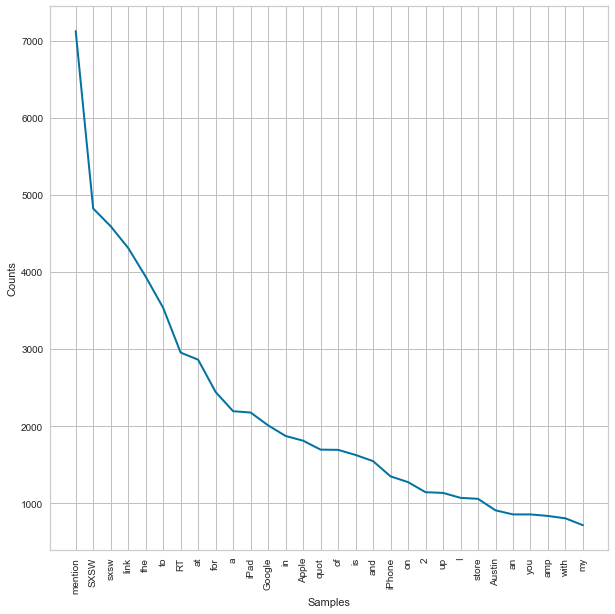

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [281]:
plt.figure(figsize=(10,10))
fdist.plot(30)

In [282]:
filtered_review = []

for w in tokenized_review:
    if w.lower() not in stopwords.words('english'):
        filtered_review.append(w.lower())

<FreqDist with 9808 samples and 115351 outcomes>


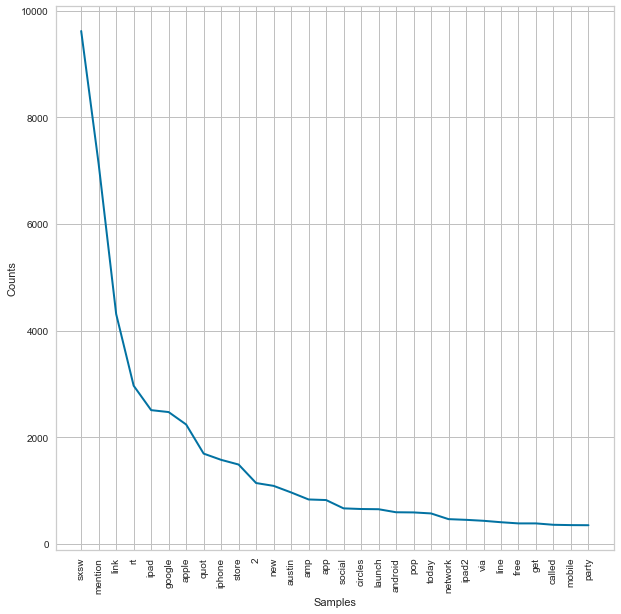

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [283]:
fdist = FreqDist(filtered_review)
print(fdist)
plt.figure(figsize=(10,10))
fdist.plot(30)

In [284]:
lemmatizer = WordNetLemmatizer()

lemmatized_review = []
for w in filtered_review:
    lemmatized_review.append(lemmatizer.lemmatize(w))


In [285]:
lemmatized_review

['wesley83',
 '3g',
 'iphone',
 '3',
 'hr',
 'tweeting',
 'rise',
 'austin',
 'dead',
 'need',
 'upgrade',
 'plugin',
 'station',
 'sxsw',
 'jessedee',
 'know',
 'fludapp',
 'awesome',
 'ipad',
 'iphone',
 'app',
 'likely',
 'appreciate',
 'design',
 'also',
 "they're",
 'giving',
 'free',
 't',
 'sxsw',
 'swonderlin',
 'wait',
 'ipad',
 '2',
 'also',
 'sale',
 'sxsw',
 'sxsw',
 'hope',
 "year's",
 'festival',
 'crashy',
 "year's",
 'iphone',
 'app',
 'sxsw',
 'sxtxstate',
 'great',
 'stuff',
 'fri',
 'sxsw',
 'marissa',
 'mayer',
 'google',
 'tim',
 "o'reilly",
 'tech',
 'book',
 'conference',
 'amp',
 'matt',
 'mullenweg',
 'wordpress',
 'teachntech00',
 'new',
 'ipad',
 'apps',
 'speechtherapy',
 'communication',
 'showcased',
 'sxsw',
 'conference',
 'http',
 'ht',
 'ly',
 '49n4m',
 'iear',
 'edchat',
 'asd',
 'unknown',
 'sxsw',
 'starting',
 'ctia',
 'around',
 'corner',
 'googleio',
 'hop',
 'skip',
 'jump',
 'good',
 'time',
 'android',
 'fan',
 'beautifully',
 'smart',
 'simpl

<FreqDist with 9061 samples and 115351 outcomes>


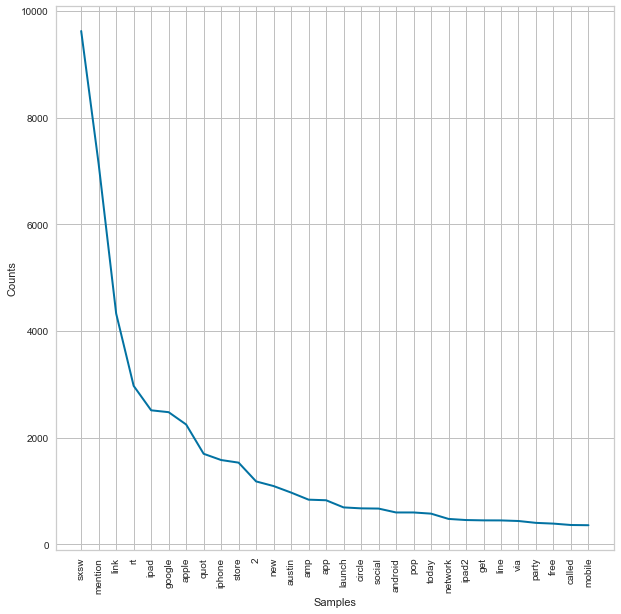

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [286]:
fdist = FreqDist(lemmatized_review)
print(fdist)
plt.figure(figsize=(10,10))
fdist.plot(30)

Words to add to stopword list: mention, link, rt, quot

In [287]:
sw_list = stopwords.words('english')
sw_list += ['mention', 'link', 'rt', 'quot']

Most Frequent Words

In [288]:
df_freq_positive = df[df['is_there_an_emotion_directed_at_a_brand_or_product'] == 'Positive emotion']
df_freq_negative = df[df['is_there_an_emotion_directed_at_a_brand_or_product'] == 'Negative emotion']

In [289]:
data_positive = df_freq_positive['tweet_text']
data_negative = df_freq_negative['tweet_text']

In [290]:
data_positive

1       @jessedee Know about @fludapp ? Awesome iPad/i...
2       @swonderlin Can not wait for #iPad 2 also. The...
4       @sxtxstate great stuff on Fri #SXSW: Marissa M...
7       #SXSW is just starting, #CTIA is around the co...
8       Beautifully smart and simple idea RT @madebyma...
                              ...                        
9072    @mention your iPhone 4 cases are Rad and Ready...
9077    @mention your PR guy just convinced me to swit...
9079    &quot;papyrus...sort of like the ipad&quot; - ...
9085    I've always used Camera+ for my iPhone b/c it ...
9088                        Ipad everywhere. #SXSW {link}
Name: tweet_text, Length: 2978, dtype: object

In [291]:
tokenizer = RegexpTokenizer(r'[a-zA-Z0-9\']+')

data_positive = data_positive.apply(lambda x: tokenizer.tokenize(x))
data_negative = data_negative.apply(lambda x: tokenizer.tokenize(x))

<FreqDist with 5020 samples and 36043 outcomes>


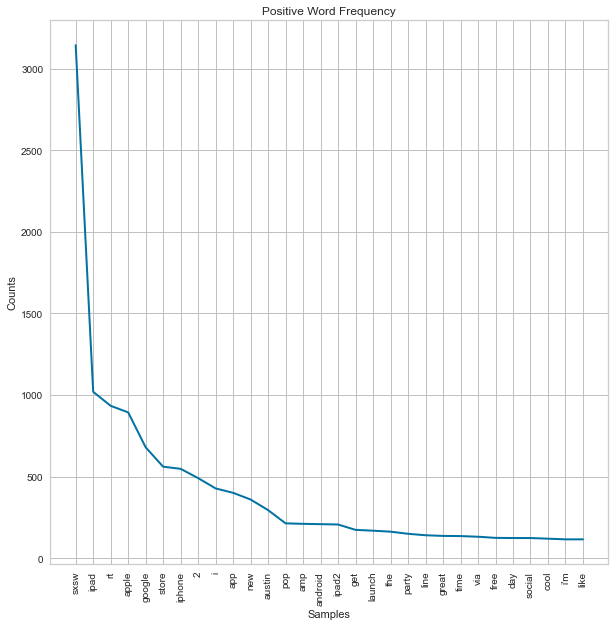

<AxesSubplot:title={'center':'Positive Word Frequency'}, xlabel='Samples', ylabel='Counts'>

In [292]:
tokenized_review = []
for row in data_positive:
    for w in row:
        if w not in sw_list:
            w = lemmatizer.lemmatize(w)
            tokenized_review.append(w.lower())

positive_fdist = FreqDist(tokenized_review)
print(positive_fdist)
plt.figure(figsize=(10,10))
plt.title('Positive Word Frequency')
positive_fdist.plot(30)

<FreqDist with 2072 samples and 7092 outcomes>


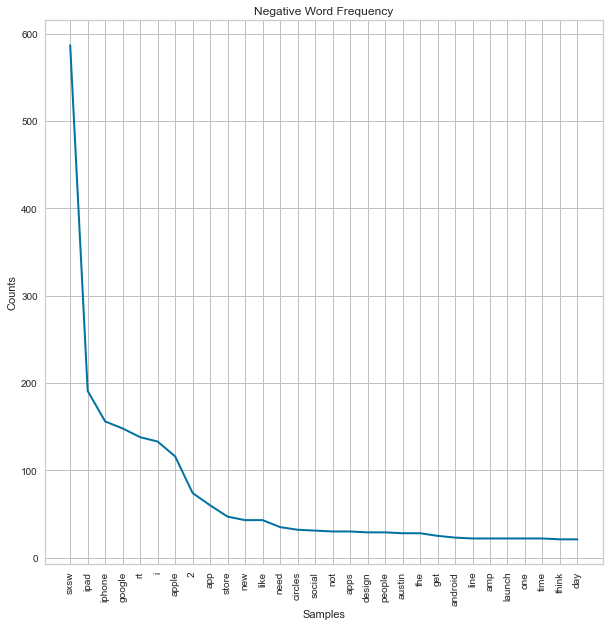

<AxesSubplot:title={'center':'Negative Word Frequency'}, xlabel='Samples', ylabel='Counts'>

In [293]:
tokenized_review = []
for row in data_negative:
    for w in row:
        if w not in sw_list:
            w = lemmatizer.lemmatize(w)
            tokenized_review.append(w.lower())

negative_fdist = FreqDist(tokenized_review)
print(negative_fdist)
plt.figure(figsize=(10,10))
plt.title('Negative Word Frequency')
negative_fdist.plot(30)

In [294]:
positive_fdist.most_common(20)

[('sxsw', 3144),
 ('ipad', 1020),
 ('rt', 934),
 ('apple', 894),
 ('google', 680),
 ('store', 561),
 ('iphone', 548),
 ('2', 491),
 ('i', 428),
 ('app', 401),
 ('new', 360),
 ('austin', 295),
 ('pop', 214),
 ('amp', 211),
 ('android', 209),
 ('ipad2', 207),
 ('get', 174),
 ('launch', 169),
 ('the', 163),
 ('party', 150)]

In [295]:
negative_fdist.most_common(20)

[('sxsw', 587),
 ('ipad', 191),
 ('iphone', 156),
 ('google', 148),
 ('rt', 138),
 ('i', 133),
 ('apple', 116),
 ('2', 74),
 ('app', 60),
 ('store', 47),
 ('new', 43),
 ('like', 43),
 ('need', 35),
 ('circles', 32),
 ('social', 31),
 ('not', 30),
 ('apps', 30),
 ('design', 29),
 ('people', 29),
 ('austin', 28)]

normalize frequencies

array([[<AxesSubplot:title={'center':'Frequency'}, xlabel='Word'>,
        <AxesSubplot:title={'center':'Normalized Frequency'}, xlabel='Word'>]],
      dtype=object)

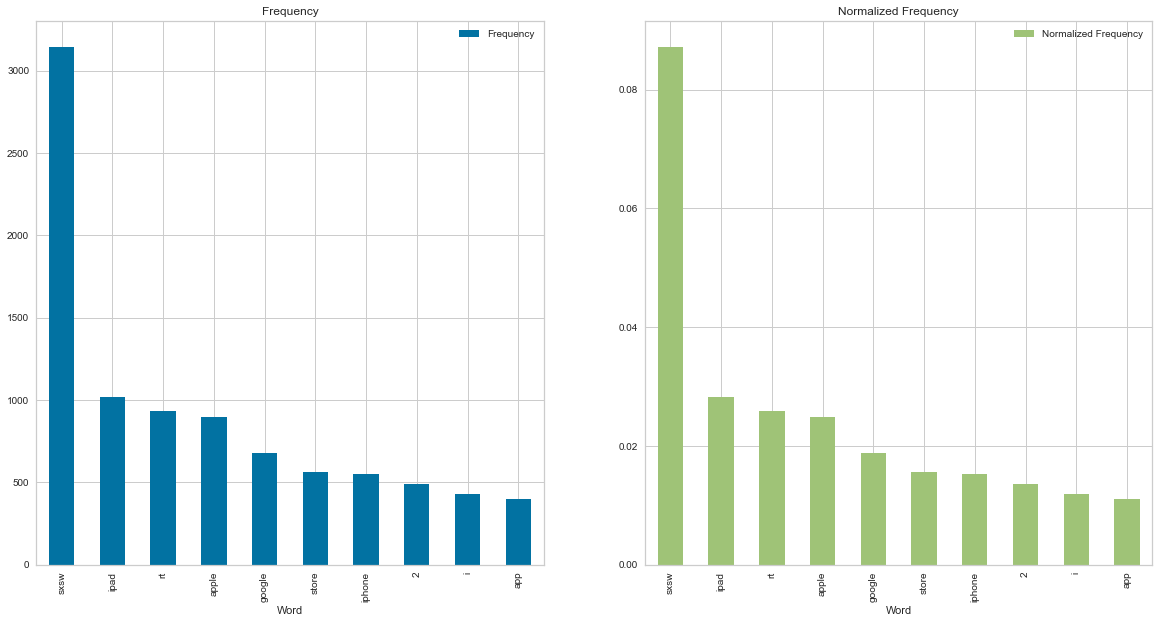

In [296]:
positive_total_word_count = sum(positive_fdist.values())
positive_tops = positive_fdist.most_common(20)
positive_frequency_df = pd.DataFrame(positive_tops, columns=['Word', 'Frequency'])
positive_frequency_df = positive_frequency_df.set_index('Word')
positive_frequency_df['Normalized Frequency'] = positive_frequency_df['Frequency']/positive_total_word_count
positive_frequency_df.nlargest(10, columns=['Frequency']).plot(kind='bar', subplots=True, sharex= False, layout=(1,2), figsize=(20,10))

<AxesSubplot:xlabel='Word'>

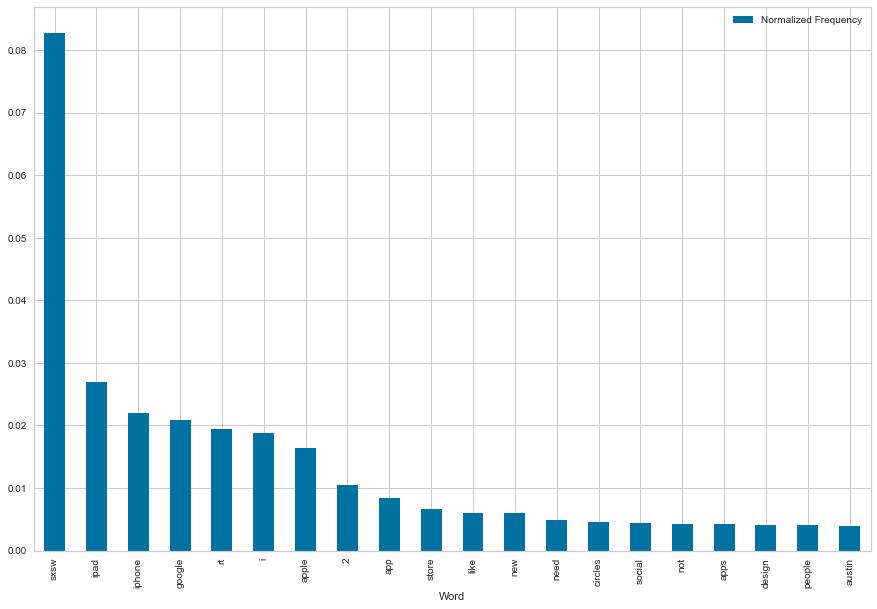

In [297]:
negative_total_word_count = sum(negative_fdist.values())
negative_tops = negative_fdist.most_common(20)
negative_frequency_df = pd.DataFrame(negative_tops, columns=['Word', 'Frequency'])
negative_frequency_df = negative_frequency_df.set_index('Word')
negative_frequency_df['Normalized Frequency'] = negative_frequency_df['Frequency']/negative_total_word_count

negative_frequency_df.nlargest(20, columns=['Frequency']).plot(kind='bar', y = 'Normalized Frequency', figsize=(15,10))

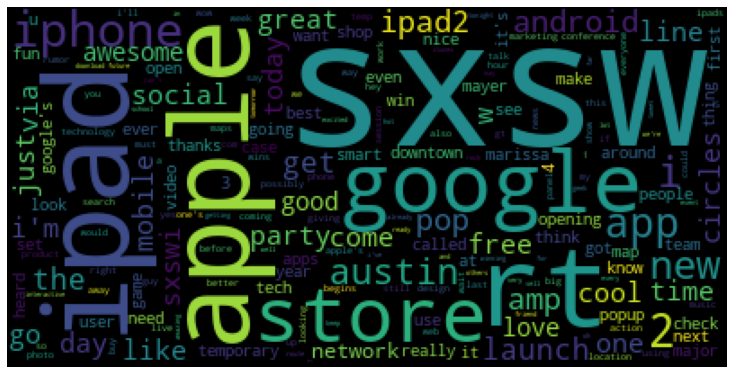

In [298]:

wordcloud = WordCloud().generate_from_frequencies(positive_fdist)

plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()

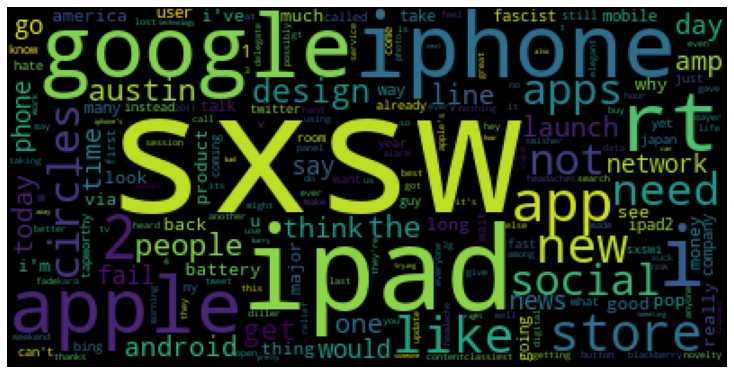

{'jessedee': 1,
 'know': 51,
 'fludapp': 1,
 'awesome': 95,
 'ipad': 1020,
 'iphone': 548,
 'app': 401,
 'likely': 2,
 'appreciate': 4,
 'design': 42,
 'also': 39,
 "they're": 19,
 'giving': 32,
 'free': 125,
 'ts': 2,
 'sxsw': 3144,
 'swonderlin': 1,
 'can': 4,
 'wait': 38,
 '2': 491,
 'they': 23,
 'sale': 17,
 'sxtxstate': 4,
 'great': 137,
 'stuff': 17,
 'fri': 5,
 'marissa': 61,
 'mayer': 66,
 'google': 680,
 'tim': 9,
 "o'reilly": 2,
 'tech': 55,
 'book': 22,
 'conference': 46,
 'amp': 211,
 'matt': 3,
 'mullenweg': 2,
 'wordpress': 3,
 'starting': 7,
 'ctia': 2,
 'around': 67,
 'corner': 5,
 'googleio': 2,
 'hop': 3,
 'skip': 2,
 'jump': 5,
 'good': 93,
 'time': 136,
 'android': 209,
 'fan': 17,
 'beautifully': 2,
 'smart': 49,
 'simple': 5,
 'idea': 23,
 'rt': 934,
 'madebymany': 7,
 'thenextweb': 1,
 'wrote': 6,
 'hollergram': 23,
 'http': 14,
 'bit': 18,
 'ly': 15,
 'ieavob': 1,
 'counting': 2,
 'day': 124,
 'plus': 8,
 'strong': 6,
 'canadian': 6,
 'dollar': 7,
 'mean': 14,
 

In [299]:
wordcloud = WordCloud().generate_from_frequencies(negative_fdist)

plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()
dict(positive_fdist)

In [300]:

#TODO: simple model, pure text search based on collection of negative and positive words


In [301]:
# lists of negative and positive words from enchantedlearning.com
from bs4 import BeautifulSoup
import requests

negative_words_url = "https://www.enchantedlearning.com/wordlist/negativewords.shtml"
positive_words_url = "https://www.enchantedlearning.com/wordlist/positivewords.shtml"

html = requests.get(negative_words_url).content

soup = BeautifulSoup(html)

negative_divs = soup.find_all("div", {"class": "wordlist-item"})

negative_words = [x.get_text() for x in negative_divs]

html = requests.get(positive_words_url).content

soup = BeautifulSoup(html)

positive_divs = soup.find_all("div", {"class": "wordlist-item"})

positive_words = [x.get_text() for x in positive_divs]

In [302]:
tokenizer = RegexpTokenizer(r'[a-zA-Z0-9\']+')
lemmatizer = WordNetLemmatizer()

r = []
data = []

for row in df['tweet_text']:
    for word in tokenizer.tokenize(row):
        r.append(lemmatizer.lemmatize(word))
    data.append(r)
    r = []

data = pd.Series(data, name='tweet_text')
target = df['is_there_an_emotion_directed_at_a_brand_or_product']

In [303]:
simple_model_df = pd.DataFrame([data, target]).transpose()

simple_model_df

,tweet_text,is_there_an_emotion_directed_at_a_brand_or_product
0,"[wesley83, I, have, a, 3G, iPhone, After, 3, h...",Negative emotion
1,"[jessedee, Know, about, fludapp, Awesome, iPad...",Positive emotion
2,"[swonderlin, Can, not, wait, for, iPad, 2, als...",Positive emotion
3,"[sxsw, I, hope, this, year's, festival, isn't,...",Negative emotion
4,"[sxtxstate, great, stuff, on, Fri, SXSW, Maris...",Positive emotion
...,...,...
9088,"[Ipad, everywhere, SXSW, link]",Positive emotion
9089,"[Wave, buzz, RT, mention, We, interrupt, your,...",No emotion toward brand or product
9090,"[Google's, Zeiger, a, physician, never, report...",No emotion toward brand or product
9091,"[Some, Verizon, iPhone, customer, complained, ...",No emotion toward brand or product


In [304]:
def word_search_model(*arg, neutral_option=True):
#     print(arg)

    tweet = arg
    sentiment_score = 0


    if type(tweet) == list:
        pass
    elif type(tweet) == tuple:
        tweet = tweet[0]
    elif type(tweet) == str:
        r = [lemmatizer.lemmatize(word) for word in tokenizer.tokenize(tweet)]
        tweet = r
#     print(tweet)

    for word in tweet:
#         print(word)
        if word in positive_words:
            sentiment_score += 1
        elif word in negative_words:
            sentiment_score -= 1
#     print(sentiment_score)
    if (
        neutral_option
        and sentiment_score > 0
        or not neutral_option
        and sentiment_score >= 0
    ):
        sentiment_score = 1
    if sentiment_score < 0:
        sentiment_score = -1

    return sentiment_score
    

In [305]:
simple_model_df['prediction'] = simple_model_df['tweet_text'].apply(word_search_model)

In [306]:
simple_model_df['prediction'].value_counts()

 0    5775
 1    2659
-1     659
Name: prediction, dtype: int64

In [307]:
simple_model_df

,tweet_text,is_there_an_emotion_directed_at_a_brand_or_product,prediction
0,"[wesley83, I, have, a, 3G, iPhone, After, 3, h...",Negative emotion,-1
1,"[jessedee, Know, about, fludapp, Awesome, iPad...",Positive emotion,1
2,"[swonderlin, Can, not, wait, for, iPad, 2, als...",Positive emotion,-1
3,"[sxsw, I, hope, this, year's, festival, isn't,...",Negative emotion,0
4,"[sxtxstate, great, stuff, on, Fri, SXSW, Maris...",Positive emotion,1
...,...,...,...
9088,"[Ipad, everywhere, SXSW, link]",Positive emotion,0
9089,"[Wave, buzz, RT, mention, We, interrupt, your,...",No emotion toward brand or product,0
9090,"[Google's, Zeiger, a, physician, never, report...",No emotion toward brand or product,-1
9091,"[Some, Verizon, iPhone, customer, complained, ...",No emotion toward brand or product,0


In [308]:
simple_model_df['is_there_an_emotion_directed_at_a_brand_or_product'] = simple_model_df['is_there_an_emotion_directed_at_a_brand_or_product'].apply(lambda x: 1 if x == 'Positive emotion' else(-1 if x == 'Negative emotion' else 0))

In [309]:
simple_model_df

,tweet_text,is_there_an_emotion_directed_at_a_brand_or_product,prediction
0,"[wesley83, I, have, a, 3G, iPhone, After, 3, h...",-1,-1
1,"[jessedee, Know, about, fludapp, Awesome, iPad...",1,1
2,"[swonderlin, Can, not, wait, for, iPad, 2, als...",1,-1
3,"[sxsw, I, hope, this, year's, festival, isn't,...",-1,0
4,"[sxtxstate, great, stuff, on, Fri, SXSW, Maris...",1,1
...,...,...,...
9088,"[Ipad, everywhere, SXSW, link]",1,0
9089,"[Wave, buzz, RT, mention, We, interrupt, your,...",0,0
9090,"[Google's, Zeiger, a, physician, never, report...",0,-1
9091,"[Some, Verizon, iPhone, customer, complained, ...",0,0


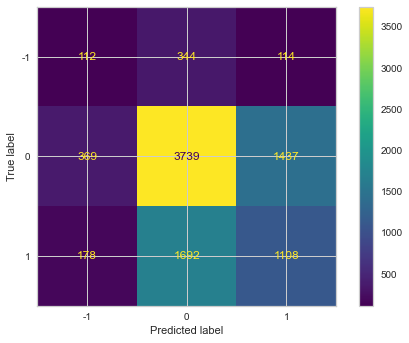

In [310]:
ConfusionMatrixDisplay.from_predictions(simple_model_df['is_there_an_emotion_directed_at_a_brand_or_product'], simple_model_df['prediction'])

# confusion_matrix(word_search_model, simple_model_df['tweet_text'], simple_model_df['is_there_an_emotion_directed_at_a_brand_or_product'])

Simple Model without neutral

In [311]:
filtered_df = df[(df['is_there_an_emotion_directed_at_a_brand_or_product'] == 'Positive emotion') | (df['is_there_an_emotion_directed_at_a_brand_or_product'] == 'Negative emotion')]

In [312]:
filtered_df = filtered_df.reset_index()

In [313]:
tokenizer = RegexpTokenizer(r'[a-zA-Z0-9\']+')
lemmatizer = WordNetLemmatizer()

r = []
data = []


for row in filtered_df['tweet_text']:
    for word in tokenizer.tokenize(row):
        r.append(lemmatizer.lemmatize(word))
    data.append(r)
    r = []

data = pd.Series(data, name='tweet_text')
target = filtered_df['is_there_an_emotion_directed_at_a_brand_or_product']

In [314]:
data

0       [wesley83, I, have, a, 3G, iPhone, After, 3, h...
1       [jessedee, Know, about, fludapp, Awesome, iPad...
2       [swonderlin, Can, not, wait, for, iPad, 2, als...
3       [sxsw, I, hope, this, year's, festival, isn't,...
4       [sxtxstate, great, stuff, on, Fri, SXSW, Maris...
                              ...                        
3543    [mention, your, PR, guy, just, convinced, me, ...
3544    [quot, papyrus, sort, of, like, the, ipad, quo...
3545    [Diller, say, Google, TV, quot, might, be, run...
3546    [I've, always, used, Camera, for, my, iPhone, ...
3547                       [Ipad, everywhere, SXSW, link]
Name: tweet_text, Length: 3548, dtype: object

In [315]:
simple_model_df = pd.DataFrame([data, target]).transpose()

simple_model_df

,tweet_text,is_there_an_emotion_directed_at_a_brand_or_product
0,"[wesley83, I, have, a, 3G, iPhone, After, 3, h...",Negative emotion
1,"[jessedee, Know, about, fludapp, Awesome, iPad...",Positive emotion
2,"[swonderlin, Can, not, wait, for, iPad, 2, als...",Positive emotion
3,"[sxsw, I, hope, this, year's, festival, isn't,...",Negative emotion
4,"[sxtxstate, great, stuff, on, Fri, SXSW, Maris...",Positive emotion
...,...,...
3543,"[mention, your, PR, guy, just, convinced, me, ...",Positive emotion
3544,"[quot, papyrus, sort, of, like, the, ipad, quo...",Positive emotion
3545,"[Diller, say, Google, TV, quot, might, be, run...",Negative emotion
3546,"[I've, always, used, Camera, for, my, iPhone, ...",Positive emotion


In [316]:
simple_model_df['prediction'] = simple_model_df['tweet_text'].apply(lambda x: word_search_model(x, neutral_option=False))

In [317]:
simple_model_df['prediction'].value_counts()

 1    3258
-1     290
Name: prediction, dtype: int64

In [318]:
simple_model_df

,tweet_text,is_there_an_emotion_directed_at_a_brand_or_product,prediction
0,"[wesley83, I, have, a, 3G, iPhone, After, 3, h...",Negative emotion,-1
1,"[jessedee, Know, about, fludapp, Awesome, iPad...",Positive emotion,1
2,"[swonderlin, Can, not, wait, for, iPad, 2, als...",Positive emotion,-1
3,"[sxsw, I, hope, this, year's, festival, isn't,...",Negative emotion,1
4,"[sxtxstate, great, stuff, on, Fri, SXSW, Maris...",Positive emotion,1
...,...,...,...
3543,"[mention, your, PR, guy, just, convinced, me, ...",Positive emotion,1
3544,"[quot, papyrus, sort, of, like, the, ipad, quo...",Positive emotion,1
3545,"[Diller, say, Google, TV, quot, might, be, run...",Negative emotion,1
3546,"[I've, always, used, Camera, for, my, iPhone, ...",Positive emotion,1


In [319]:
simple_model_df['is_there_an_emotion_directed_at_a_brand_or_product'] = simple_model_df['is_there_an_emotion_directed_at_a_brand_or_product'].apply(lambda x: 1 if x == 'Positive emotion' else(-1 if x == 'Negative emotion' else 0))

In [320]:
simple_model_df

,tweet_text,is_there_an_emotion_directed_at_a_brand_or_product,prediction
0,"[wesley83, I, have, a, 3G, iPhone, After, 3, h...",-1,-1
1,"[jessedee, Know, about, fludapp, Awesome, iPad...",1,1
2,"[swonderlin, Can, not, wait, for, iPad, 2, als...",1,-1
3,"[sxsw, I, hope, this, year's, festival, isn't,...",-1,1
4,"[sxtxstate, great, stuff, on, Fri, SXSW, Maris...",1,1
...,...,...,...
3543,"[mention, your, PR, guy, just, convinced, me, ...",1,1
3544,"[quot, papyrus, sort, of, like, the, ipad, quo...",1,1
3545,"[Diller, say, Google, TV, quot, might, be, run...",-1,1
3546,"[I've, always, used, Camera, for, my, iPhone, ...",1,1


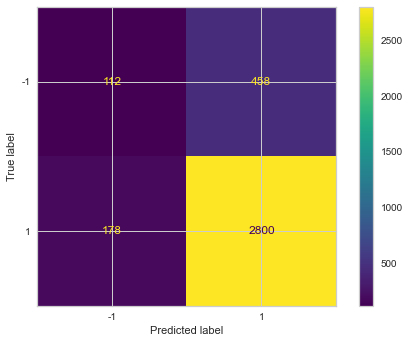

In [321]:
ConfusionMatrixDisplay.from_predictions(simple_model_df['is_there_an_emotion_directed_at_a_brand_or_product'], simple_model_df['prediction'])

# confusion_matrix(word_search_model, simple_model_df['tweet_text'], simple_model_df['is_there_an_emotion_directed_at_a_brand_or_product'])

classify


In [325]:
# models = [({'classifier': 'lr', 'transformer': 'tfidfv'}, lr),
#           ({'classifier': 'Tree', 'transformer': 'tfidfv'}, tree),
#           ({'classifier': 'RandomForest', 'transformer': 'tfidfv'}, rf)
#          ]

class ModelRunner:
    """
    For evaluating a pipeline or series of pipelines for their effectiveness at predicting the target in this sentiment analysis.
    
    ...
    Attributes
    ----------
    model : tuple or list
        the first index is expected to be a dictionary with the names of the classifier and transformer being used for the pipeline being passed in. the second index should be the pipeline object
    neutral : bool
        whether neutral sentiment is a possible target, i.e. is this a multiclass problem
    data : pandas.DataFrame or pandas.Series
        the tweets used to predict the target, usually refered to as X
    target : pandas.Series
        the feature being predicted, usually refered to as y
    
    
    Methods
    -------
    run_model():
        Evaluates the provided pipelines and returns statistical scores, the ROC-AUC graph, a bar graph containing the 20 most influential words, as well as a bar graph displaying the prevelence of those words in factually positive and negative tweets.
    """
    
    
    def __init__(self, model, neutral, data, target):
        self.neutral = neutral
        self.classifer_name = model[0]['classifier']
        self.transformer_name = model[0]['transformer']
        self.clf = model[1]
        self.data = data
        self.target = target
        self.random_state = 42
        self.score = {}


        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.data, self.target, random_state = self.random_state)


    def __evaluate(self, output = False):


        #     grab predictions
        train_preds = self.clf.predict(self.X_train)
        val_preds = self.clf.predict(self.X_test)

    #     output needed for roc_auc score
#         if roc_auc == 'skip':
#             train_out = False
#             val_out = False
#         elif roc_auc == 'dec': # not all classifiers have a decision function
#             train_out = self.clf.decision_function(self.X_train)
#             val_out = self.clf.decision_function(self.X_test)
#         elif roc_auc == 'proba':
        try:
            train_out = self.clf.predict_proba(self.X_train)
            val_out = self.clf.predict_proba(self.X_test)
        except AttributeError:
            train_out = self.clf.predict(self.X_train)
            val_out = self.clf.predict(self.X_test)

#         else:
#             raise Exception("The value for roc_auc should be 'skip', 'dec', or 'proba'.")

        ac = accuracy_score(self.y_train, train_preds)
    
        if self.neutral:
            f1 = f1_score(self.y_train, train_preds, pos_label='Positive emotion', average='macro')
            ras = roc_auc_score(self.y_train, train_out, multi_class='ovo')
            pr = precision_score(self.y_train, train_preds, pos_label='Positive emotion', average='macro')
        else:
#             try:
#                 print('hit1')
#                 f1 = f1_score(self.y_train, train_preds, pos_label='Positive emotion')
#                 ras = roc_auc_score(self.y_train, train_out)
#                 pr = precision_score(self.y_train, train_preds, pos_label='Positive emotion')

#             except ValueError:
            f1 = f1_score(self.y_train, train_preds, pos_label='Positive emotion')
            ras = roc_auc_score(self.y_train, train_out[:,1])
            pr = precision_score(self.y_train, train_preds, pos_label='Positive emotion')
                

#           tracking scores and their associated models


        self.score[str(self.clf['scaler']) + ' ' + str(self.clf['classifier'])] = {'train': {'f1' : f1,
                                                                               'roc-auc' : ras,
                                                                               'ac' : ac,
                                                                               'pr' : pr
                                                                              }}
        if output:
            print('Train Scores')
            print('------------')
            print(f'Accuracy: {ac}')
            print(f'F1 Score: {f1}')
            if type(train_out) == np.ndarray:
                print(f'ROC-AUC: {ras}')
            print(f'Precision: {pr}')

        ac = accuracy_score(self.y_test, val_preds)
        
        if self.neutral:
            f1 = f1_score(self.y_test, val_preds, pos_label='Positive emotion', average='macro')
            ras = roc_auc_score(self.y_test, val_out, multi_class='ovo')
            pr = precision_score(self.y_test, val_preds, pos_label='Positive emotion', average='macro')
        else:
#             try:
#                 f1 = f1_score(self.y_test, val_preds, pos_label='Positive emotion')
#                 ras = roc_auc_score(self.y_test, val_out)
#                 pr = precision_score(self.y_test, val_preds, pos_label='Positive emotion')

#             except ValueError:
            f1 = f1_score(self.y_test, val_preds, pos_label='Positive emotion')
            ras = roc_auc_score(self.y_test, val_out[:,1])
            pr = precision_score(self.y_test, val_preds, pos_label='Positive emotion')
                
        score[str(self.clf['scaler']) + ' ' + str(self.clf['classifier'])]['test'] = {'f1' : f1,
                                                                                       'roc-auc' : ras,
                                                                                       'ac' : ac,
                                                                                       'pr' : pr
                                                                                      }
                
        if output:
            print('-----------------------------------')
            print('Test Scores')
            print('-----------')
            print(f'Accuracy: {ac}')
            print(f'F1 Score: {f1}')
            if type(val_out) == np.ndarray:
                print(f'ROC-AUC: {ras}')
            print(f'Precision: {pr}')

        
            plot_confusion_matrix(self.clf, self.X_test, self.y_test, values_format=',.5g')
            plt.show()


    def run_model(self):

        self.clf.fit(self.X_train, self.y_train)
        self.__evaluate(output=True)

        visualizer = ROCAUC(self.clf, classes = self.y_train.unique())

        # Fitting to the training data first then scoring with the test data
        if self.neutral:
            visualizer.fit(self.X_train, self.y_train)
            visualizer.score(self.X_test, self.y_test)
        else:
            visualizer.fit(self.X_train, self.y_train.map({'Positive emotion': 1, 'Negative emotion': 0}).astype(int))
            visualizer.score(self.X_test, self.y_test.map({'Positive emotion': 1, 'Negative emotion': 0}).astype(int))
        visualizer.show()
    #     plot_roc_curve(clf, X_val, y_val)
    #     plt.show()

        try:
            importances = sorted(list(zip(self.clf[self.classifer_name].feature_importances_, self.clf[self.transformer_name].get_feature_names())))[-20:]
        except AttributeError:
            importances = sorted(list(zip(self.clf[self.classifer_name].coef_[0], self.clf[self.transformer_name].get_feature_names())))[-20:]

        impts = pd.DataFrame(importances, columns=['impt', 'feat'])
        impts = impts.set_index('feat')
        impts.plot(kind='barh')
        plt.show()
        impts = impts.reset_index()
        impts['positive_appearences'] = impts['feat'].apply(lambda x: positive_fdist[x])
        impts['negative_appearences'] = impts['feat'].apply(lambda x: negative_fdist[x])
        impts.plot(x = 'feat', y=['positive_appearences', 'negative_appearences'], kind='bar')
#         impts.show()
#         X = []
# #         y = []
#         yp = []
#         yn = []
#         for index, row in impts.sort_values('impt', ascending=False).iterrows():
# #             print(index)
# #             print('Positive Appearences: {}'.format(positive_fdist[index]))
# #             print('Negative Appearences: {}\n'.format(negative_fdist[index]))

#             X.append(index)
#             yp.append(positive_fdist[index])
#             yn.append(negative_fdist[index])
# #             y.append((positive_fdist[index], negative_fdist[index]))
# #         plt.bar(X, y)
# #         ind = np.arrange(20)
# #         ax = plt.figure()
# #         ax.bar(X, yp, width)
# #         ax.bar(X, yn)
#         sns.barplot(x=X, y=zip(yp, yn))
#         plt.show()

In [327]:
simplified_target_df = df.copy()
simplified_target_df['is_there_an_emotion_directed_at_a_brand_or_product'] = simplified_target_df['is_there_an_emotion_directed_at_a_brand_or_product'].apply(lambda x: 1 if x == 'Positive emotion' else(-1 if x == 'Negative emotion' else 0))

In [337]:
# tokenizer = RegexpTokenizer(r'[a-zA-Z0-9\']+')
# lemmatizer = WordNetLemmatizer()

# r = []
# data = []

# for row in simplified_target_df['tweet_text']:
#     for word in tokenizer.tokenize(row):
#         if word not in sw_list:
#             r.append(lemmatizer.lemmatize(word))
#     data.append(' '.join(r))
#     r = []

data = simplified_target_df['tweet_text']
target = simplified_target_df['is_there_an_emotion_directed_at_a_brand_or_product']

In [338]:
data

0       .@wesley83 I have a 3G iPhone. After 3 hrs twe...
1       @jessedee Know about @fludapp ? Awesome iPad/i...
2       @swonderlin Can not wait for #iPad 2 also. The...
3       @sxsw I hope this year's festival isn't as cra...
4       @sxtxstate great stuff on Fri #SXSW: Marissa M...
                              ...                        
9088                        Ipad everywhere. #SXSW {link}
9089    Wave, buzz... RT @mention We interrupt your re...
9090    Google's Zeiger, a physician never reported po...
9091    Some Verizon iPhone customers complained their...
9092    Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...
Name: tweet_text, Length: 9093, dtype: object

In [339]:
# X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=42)


# tfidf_data_train = tfidf.fit_transform(X_train)
# tfidf_data_test = tfidf.transform(X_test)

# tfidf_data_train

# Let's just play with logistic regression for now

## iterate through different options

- scaler
- max_iter
- class_weight
- penalty
- C
- solver

Using RandomizedSearchCV instead of GridSearchCV because with so many different options GridSearchCV was taking a very long time

In [340]:
len(set(positive_fdist + negative_fdist))

5827

In [ ]:
models = []

for scaler in [MaxAbsScaler(), StandardScaler(with_mean=False), RobustScaler(with_centering=False)]:

#     models = [({'classifier': 'lr', 'transformer': 'tfidfv'}, lr),
#               ({'classifier': 'Tree', 'transformer': 'tfidfv'}, tree),
#               ({'classifier': 'RandomForest', 'transformer': 'tfidfv'}, rf)
#              ]
    
    search_models = [LogisticRegression(random_state=42),
                     DecisionTreeClassifier(random_state=42, class_weight='balanced'),
                    RandomForestClassifier(random_state=42, class_weight='balanced')
                    ]
    
    search_space = [{ 'max_iter': [100, 1000, 5000],
                      'class_weight': ['balanced', None],
                      'penalty': ['l1', 'l2'],
                      'C': np.linspace(0, 100, 8),
                      'solver': ['newton-cg', 'sag', 'saga', 'lbfgs']
                          },
                   {
                       'criterion': ['gini', 'entropy'],
                       'splitter': ['best', 'random'],
                       'max_depth': [10, 50, 100],
#                        according to towardsdatascience.com, ideal split is between 1 and 40
                       'min_samples_split': [2, 20, 40],
#                        Given the 5827 unique words it'll be helpful to limit features for computation time
                       'max_features': ['sqrt', 'log2']
                   },
                   {
                       'criterion': ['gini', 'entropy'],                       
                       'bootstrap': [True, False],
                       'max_depth': [10, 50, 100],
                       'max_features': ['auto', 'sqrt'],
                       'min_samples_split': [2, 20, 40],
                       'n_estimators': [200, 1000, 2000]
                   }]

#     log_reg_obj = LogisticRegression()
    for model, params in zip(search_models, search_space):
        grid = RandomizedSearchCV(model, params, scoring='accuracy', random_state=42)

        pipe = Pipeline([('tfidfv', TfidfVectorizer(stop_words=sw_list)),
                   ('scaler', scaler),
                    ('classifier', grid)])

        pipe.fit(data, target)

        print(grid.best_params_)
    
        estimator = model.set_params(**grid.best_params_)

        pipe = Pipeline([('tfidfv', TfidfVectorizer(stop_words=sw_list)),
                       ('scaler', scaler),
                        ('classifier', estimator)])
        models.append(({'classifier': 'classifier', 'transformer': pipe.steps[0][0]}, pipe))
        
    
#     tree = Pipeline([('tfidfv', TfidfVectorizer(stop_words=sw_list)),
#                      ('scaler', StandardScaler()),
#                     ('Tree', DecisionTreeClassifier())])

#     rf = Pipeline([('tfidfv', TfidfVectorizer(stop_words=sw_list)),
#                    ('scaler', StandardScaler()),               
#                     ('RandomForest', RandomForestClassifier())])

    

#     scores = [(name['classifier'], cross_val_score(model, simplified_target_df['tweet_text'], target, error_score='raise').mean()) for name, model, in models]

#     print(scores)

In [ ]:
scores = [(name['classifier'], cross_val_score(model, simplified_target_df['tweet_text'], target, error_score='raise').mean()) for name, model, in models]

print(scores)

RobustScaler with the below hyperparameters appear to be the best options for logistic regression. Let's take a more thurough look at that model

{'solver': 'saga', 'penalty': 'l1', 'max_iter': 100, 'class_weight': None, 'C': 71.42857142857143}


In [ ]:
for each in models:
    print(each[0]['transformer'])

In [ ]:
for each in models:
    print(str(each[1]['scaler']))
    break

In [ ]:
for each in models:
    print(each[1]['classifier'])
    mr = ModelRunner(model = each, neutral = True, data = data, target = target)
    mr.run_model()

models 7 and 9 have the best test accuracy and roc-auc scores, my prefered metrics for this particular problem. both used the RobustScaler. however all the models show serious overfitting. let's try to tinker with those two and see if we can get a more generalizable model.

In [ ]:
param_range = [0.001,0.01,0.1,1,10,100,1000]

lr = LogisticRegression().set_params(**{'solver': 'saga', 'penalty': 'l2', 'max_iter': 5000, 'class_weight': None, 'C': 57.142857142857146})

train_scores, test_scores = validation_curve(estimator = lr,
                              X=TfidfVectorizer(stop_words=sw_list).fit_transform(data),
                              y = target,
                              param_name='C',
                              param_range=C_param_range)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with SVM")
# plt.xlabel(r"$\C$")
plt.ylabel("Score")
# plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

C was clearly way too high. This suggests it should be around .01. Let's see what that does for overfitting

In [ ]:
lr = LogisticRegression().set_params(**{'penalty': 'l2', 'max_iter': 5000, 'class_weight': None, 'C': .01})
# rf = RandomForestClassifier().set_params({'n_estimators': 1000, 'min_samples_split': 2, 'max_features': 'auto', 'max_depth': 50, 'criterion': 'entropy', 'bootstrap': True})
# for each in [lr, rf]:
pipe = Pipeline([('tfidfv', TfidfVectorizer(stop_words=sw_list)),
                       ('scaler', RobustScaler(with_centering=False)),
                        ('classifier', LogisticRegression(solver='saga', max_iter = 5000, C=.01, random_state=42))])

models.append(({'classifier': pipe.steps[2][0], 'transformer': pipe.steps[0][0]}, pipe))
    
# for each in models[-1]:
mr = ModelRunner(model = models[-1], neutral = True, data = data, target = target)
mr.run_model()

Now it's just guessing the majority class. Perhaps C wasn't the correct hyperparamter to tweek. Let's try max_iter.

In [ ]:
param_range = [-100,-10,1,10,100,1000,3000,5000,9000]

lr = LogisticRegression().set_params(**{'solver': 'saga', 'penalty': 'l2', 'max_iter': 5000, 'class_weight': None, 'C': 57.142857142857146})

train_scores, test_scores = validation_curve(estimator = lr,
                              X=TfidfVectorizer(stop_words=sw_list).fit_transform(data),
                              y = target,
                              param_name='max_iter',
                              param_range=param_range)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with SVM")
# plt.xlabel(r"$\C$")
plt.ylabel("Score")
# plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

The training and cross-validation scores never intersect though this would suggest that a max_iter of 1 would be ideal. 

In [ ]:
models[]

In [257]:
pipe.steps[2][0]

'classifier'

In [ ]:
estimator = LogisticRegression().set_params(**grid.best_params_)

lr = Pipeline([('tfidfv', TfidfVectorizer(stop_words=sw_list)),
               ('scaler', StandardScaler()),
                ('lr', estimator)])

tree = Pipeline([('tfidfv', TfidfVectorizer(stop_words=sw_list)),
                 ('scaler', StandardScaler()),
                ('Tree', DecisionTreeClassifier())])

rf = Pipeline([('tfidfv', TfidfVectorizer(stop_words=sw_list)),
               ('scaler', StandardScaler()),               
                ('RandomForest', RandomForestClassifier())])

models = [({'classifier': 'lr', 'transformer': 'tfidfv'}, lr),
          ({'classifier': 'Tree', 'transformer': 'tfidfv'}, tree),
          ({'classifier': 'RandomForest', 'transformer': 'tfidfv'}, rf)
         ]

scores = [(name['classifier'], cross_val_score(model, data, target, cv=2).mean()) for name, model, in models]

scores

In [ ]:
for each in models:
    mr = ModelRunner(model = each, neutral = True, data = data, target = target)
    mr.run_model()

# re-do without no emotion, can't tell

In [ ]:
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

In [ ]:
filtered_df = df[(df['is_there_an_emotion_directed_at_a_brand_or_product'] == 'Positive emotion') | (df['is_there_an_emotion_directed_at_a_brand_or_product'] == 'Negative emotion')]

In [ ]:
filtered_df = filtered_df.reset_index()

In [ ]:
tokenizer = RegexpTokenizer(r'[a-zA-Z0-9\']+')
lemmatizer = WordNetLemmatizer()

r = []
data = []

for row in filtered_df['tweet_text']:
    for word in tokenizer.tokenize(row):
        r.append(lemmatizer.lemmatize(word))
    data.append(' '.join(r))
    r = []

data = pd.Series(data, name='tweet_text')
target = filtered_df['is_there_an_emotion_directed_at_a_brand_or_product']

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=42)


# tfidf_data_train = tfidf.fit_transform(X_train)
# tfidf_data_test = tfidf.transform(X_test)

# tfidf_data_train

In [ ]:
lr = Pipeline([('tfidfv', TfidfVectorizer(stop_words=sw_list)),
               ('scaler', MinMaxScaler()),
                ('lr', LogisticRegression())])

tree = Pipeline([('tfidfv', TfidfVectorizer(stop_words=sw_list)),
                 ('scaler', MinMaxScaler()),
                ('Tree', DecisionTreeClassifier())])

rf = Pipeline([('tfidfv', TfidfVectorizer(stop_words=sw_list)),
               ('scaler', MinMaxScaler()),               
                ('RandomForest', RandomForestClassifier())])

models = [({'classifier': 'lr', 'transformer': 'tfidfv'}, lr),
          ({'classifier': 'Tree', 'transformer': 'tfidfv'}, tree),
          ({'classifier': 'RandomForest', 'transformer': 'tfidfv'}, rf)
         ]

scores = [(name['classifier'], cross_val_score(model, data, target, cv=2).mean()) for name, model, in models]

scores

In [ ]:
for each in models:
    mr = ModelRunner(model = each, neutral = False, data = data, target = target)
    mr.run_model()

In [ ]:
#TODO: logistic regression

# WORD VECTORIZATION

In [ ]:
word_list = []

for w in fdist.keys():
    if w not in sw_list:
        w = lemmatizer.lemmatize(w)
        word_list.append(w.lower())

In [ ]:
glove = {}
with open('glove.twitter.27B.25d.txt', 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in word_list:
            vector = np.array(parts[1:], dtype=np.float32)
            glove[word] = vector

In [ ]:
glove

In [ ]:
len(glove)

In [ ]:
class W2vVectorizer(object):
    
    def __init__(self, w2v):
        # Takes in a dictionary of words and vectors as input
        self.w2v = w2v
        self.dimensions = 0 if len(w2v) == 0  else self.dimensions = len(w2v[next(iter(glove))])
    
    # Note: Even though it doesn't do anything, it's required that this object implement a fit method or else
    # it can't be used in a scikit-learn pipeline  
    def fit(self, X, y):
        return self
            
    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

lsvc = Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
                ('LinearSVC', LinearSVC())])

tree = Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
                ('Tree', DecisionTreeClassifier())])

In [ ]:
lr = Pipeline([('tfidfv', TfidfVectorizer(stop_words=sw_list)),
                ('lr', LogisticRegression())])

tree = Pipeline([('tfidfv', TfidfVectorizer(stop_words=sw_list)),
                ('Tree', DecisionTreeClassifier())])

rf = Pipeline([('tfidfv', TfidfVectorizer(stop_words=sw_list)),
                ('RandomForest', RandomForestClassifier())])

models = [('lr', lr),
          ('Tree', tree),
          ('RandomForest', rf)
         ]

scores = [(name, cross_val_score(model, data, target, cv=2).mean()) for name, model, in models]

scores

In [ ]:
for name, model in models:
    run_model(name, model, X_train, X_test, y_train, y_test)

In [ ]:
#TODO: decision tree
#TODO: show metrics for why complex over simple model
#TODO: iterate models when justified